### Optimization Targets:

1. We want to achieve daily calorie limits intake
2. We want to have as many food of same cluster to be in the food

### Import Data and Libraries

Data and Baseline Code has been adapted from here: https://github.com/yoke2/ISA-SLS-IS1FT-GRP-A22G-FoodAndWorkoutRecommender/blob/master/NotebooksAndData/01_GA_Food_Recommender_V1.0.ipynb

In [21]:
import gdown
from zipfile import ZipFile
gdown.download('https://drive.google.com/uc?export=download&id=11C8lWqT1Bqva_2NYkoGMqvX5ZF5SVJ4k', 'sls_data.zip', quiet=True)

with ZipFile('sls_data.zip', 'r') as zipObj:
   zipObj.extractall()

In [22]:
import random
import pandas as pd
import matplotlib.pyplot as plt
from pandas import DataFrame
import numpy as np

In [23]:

data = pd.read_csv("food.csv")
weeklyCalories = 1800 * 7

food = data['Food']
calories = data['Calories']
utility = data['Utility']
carbo = data['Carbohydrate']
fat = data['Fat']

In [24]:
# foods item of similar cluster  have same cluster values
#We want as many food of same cluster to be together
cluster_values = [random.randint(1,5) for _ in range(len(food))]
week_day = [random.randint(1,3) for _ in range(len(food))]


In [25]:
data['cluster_values'] = cluster_values

### GA Defintions

In [26]:
populationSize = 50
numberOfGenerations = 100
crossOverRate = 0.5
rateOfMutation = 0.01

currentGen = []
currentBestSolution = []
highestScoreList = []
averageScoreList = []

#Initialise a Population
listofones = [1]*21
listofzeros = [0]*(len(food)-21)

for i in range (populationSize):
    currentGen. append(listofones + listofzeros)
    random.shuffle(currentGen[i])

In [27]:
#Define the fitness function here
def compute_similarity_reward(individual):
  check_list = [0,0,0,0,0]
  for i in range(len(individual)):
    if individual[i]==1:
      cv = cluster_values[i]
      check_list[cv-1] +=1
  max_value = max(check_list)
  return max_value/len(individual)

def compute_daytime_reward(individual):
  check_list = [0,0,0]
  for i in range(len(individual)):
    if individual[i]==1:
      cv = week_day[i]
      check_list[cv-1] +=1
  mean_values =  -sum([np.abs(item-7) for item in check_list])
  return mean_values/100

def reward_day(check_list):
  mean_values =  -sum([np.abs(item-7) for item in check_list])
  return mean_values/100




### GA Simulation

In [28]:
rewards_factor = [0,10,50,100,500,1000]
results = list()
combined_result = list()
calories_result = list()
day_reward = list()
for factor in rewards_factor:
  for g in range (numberOfGenerations):
      
      fitnessScore = [0]*populationSize
      normalisedFitnessScore = [0]*populationSize
      totalPolulationFitnessScore = 0
      highestScore = 0
      nextGen = []
      newGen = []

      # Perform Evaluation of Fitness Score
      for i in range (populationSize):
          totalCalories = 0
          for j in range (len(food)):
              fitnessScore[i] += currentGen[i][j] * utility[j]
              fitnessScore[i] += compute_similarity_reward(currentGen[i])*factor
              fitnessScore[i] += compute_daytime_reward(currentGen[i])*factor
              totalCalories += currentGen[i][j] * calories[j]
          if totalCalories > weeklyCalories:
              fitnessScore[i] += weeklyCalories - totalCalories
          if fitnessScore[i] > highestScore:
              currentBestSolutionIndex = i
              highestScore = fitnessScore[i]

          totalPolulationFitnessScore += fitnessScore[i]
          
      highestScoreList.append(highestScore)
      averageScoreList.append(totalPolulationFitnessScore/populationSize)    
      currentBestSolution = currentGen[currentBestSolutionIndex].copy()

      for i in range (populationSize):
          normalisedFitnessScore[i] = fitnessScore[i]/totalPolulationFitnessScore

      #Perform Selection
      for i in range (populationSize):
          cumulativeNormalisedFitnessScore = 0
          rwScore = random.uniform(0, 1)
          for j in range (populationSize):
              cumulativeNormalisedFitnessScore += normalisedFitnessScore[j]
              if cumulativeNormalisedFitnessScore >= rwScore:
                  nextGen.append(currentGen[j].copy())
                  break    

      #Perform Cross Over
      for i in range (int(populationSize/2)):
          if crossOverRate > random.uniform(0, 1):

              randomNumber1 = random.randint(0, len(food)-1)
              randomNumber2 = random.randint(0, len(food)-1)

              if randomNumber1 > randomNumber2:
                  crossOverPoint1 = randomNumber2
                  crossOverPoint2 = randomNumber1
              else:
                  crossOverPoint1 = randomNumber1
                  crossOverPoint2 = randomNumber2

              child1 = nextGen[i][0:crossOverPoint1] + nextGen[i+int(populationSize/2)][crossOverPoint1:crossOverPoint2] + nextGen[i][crossOverPoint2:]
              child2 = nextGen[i+int(populationSize/2)][0:crossOverPoint1] + nextGen[i][crossOverPoint1:crossOverPoint2] + nextGen[i+int(populationSize/2)][crossOverPoint2:]

              nextGen[i] = child1.copy()
              nextGen[i+int(populationSize/2)] = child2.copy()

      #Perform Mutation
      for i in range (populationSize):
          for j in range (len(food)):
              if rateOfMutation > random.uniform(0, 1):
                  nextGen[i][j] = abs(nextGen[i][j] - 1)

      #Adjust bits back to zero
      for i in range (populationSize):
          bitsToAdjust = sum(nextGen[i]) - 21

          if bitsToAdjust > 0:
              for j in range (bitsToAdjust):
                  index = random.randint(0, len(food)-1)
                  notFound = True
                  while notFound:
                      if nextGen[i][index] == 1:
                          nextGen[i][index] = 0
                          notFound = False
                      else:
                          index += 1
                          index  = index%len(food)
          elif bitsToAdjust < 0:
              for j in range (abs(bitsToAdjust)):
                  index = random.randint(0, len(food)-1)
                  notFound = True
                  while notFound:
                      if nextGen[i][index] == 0:
                          nextGen[i][index] = 1
                          notFound = False
                      else:
                          index += 1
                          index  = index%len(food) 
      
      #Forming a new Generation by getting fitest half from currentGen and fitest half from nextGen
      for i in range (populationSize):
          count = 0
          for j in range (populationSize):
              if fitnessScore[i] > fitnessScore[j]:
                  count += 1
          if count >= int(populationSize/2):
              newGen.append(currentGen[i].copy())
      
      fitnessScore = [0]*populationSize
    
      for i in range (populationSize):
          totalCalories = 0
          for j in range (len(food)):
              fitnessScore[i] += nextGen[i][j] * utility[j]
              totalCalories += nextGen[i][j] * calories[j]
          if totalCalories > weeklyCalories:
              fitnessScore[i] += weeklyCalories - totalCalories
      
      for i in range (populationSize):
          count = 0
          for j in range (populationSize):
              if fitnessScore[i] > fitnessScore[j]:
                  count += 1
          if count >= int(populationSize/2):
              newGen.append(nextGen[i].copy())
              
      for i in range (populationSize-len(newGen)):
          newGen.append(nextGen[random.randint(0, populationSize-1)].copy())
      
      currentGen = newGen.copy()

  #Store the results
  final_cluster_list = [0,0,0,0,0]
  totalcalories = 0
  food_values = list()
  dr = list()
  for i in range (len(food)):
      if currentBestSolution[i] == 1:
          totalcalories += calories[i]
          food_values.append((i,food[i],cluster_values[i],week_day[i]))
          #print(food[i],cluster_values[i])
          final_cluster_list[cluster_values[i]-1] +=1
          dr.append(week_day[i])
  results.append(food_values)
  combined_result.append(max(final_cluster_list))
  calories_result.append(totalcalories/7)
  day_reward.append(reward_day(dr))


  


### Results

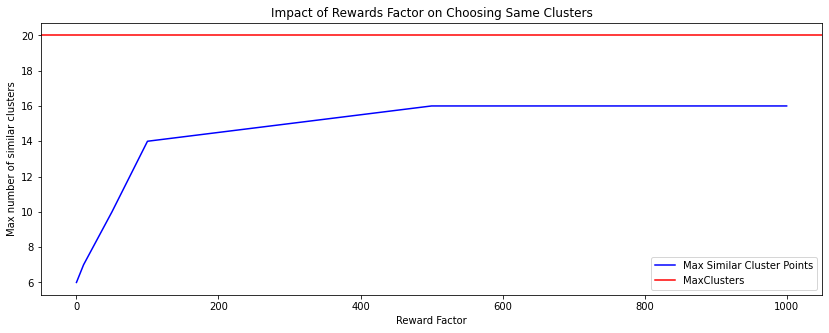

In [29]:
fig = plt.figure(figsize = (14, 5))
 
# creating the bar plot
plt.plot(rewards_factor, combined_result, color ='b',label = 'Max Similar Cluster Points')
plt.xlabel("Reward Factor")
plt.axhline(y=20,linewidth=1.5, color='r',label='MaxClusters')
plt.ylabel("Max number of similar clusters")
plt.title("Impact of Rewards Factor on Choosing Same Clusters")
plt.legend()
plt.show()

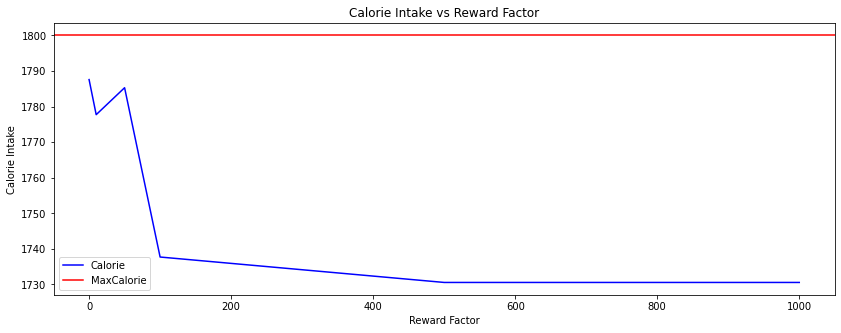

In [30]:
fig = plt.figure(figsize = (14, 5))
plt.plot(rewards_factor, calories_result, color ='b',label = 'Calorie')
plt.axhline(y=1800,linewidth=1.5, color='r',label='MaxCalorie')
plt.xlabel("Reward Factor")
plt.ylabel("Calorie Intake")
plt.title("Calorie Intake vs Reward Factor")
plt.legend()
plt.show() 

We can see that we are under our target 1800 calories and has achieved max 16 similar foods together.

In [32]:
#Let' check sample foods predicted, with (index, food, cluster)
results[-1]

[(3, 'Claypot Rice', 5, 2),
 (7, 'Ngoh Hiang Mixed Items', 4, 3),
 (8, 'Lontong with Sayur Lodeh', 5, 3),
 (14, 'Mee Siam', 5, 1),
 (25, 'Braised Duck With Yam Rice', 5, 2),
 (29, 'Shrimp Fried Rice', 5, 1),
 (30, 'Mee Rebus', 5, 2),
 (33, 'Nasi Lemak', 4, 1),
 (38, 'Pork Satay with Sauce (10 sticks)', 2, 3),
 (40, 'Waffles with Kaya', 5, 3),
 (41, 'Fried Beehoon', 5, 1),
 (42, 'Masala Thosai', 5, 3),
 (47, 'Lor Mai Kai', 5, 2),
 (53, 'Goreng Pisang (2 pieces)', 5, 2),
 (55, 'Pizza (2 slices)', 2, 1),
 (56, 'Carbonara', 5, 2),
 (57, 'Butter Crab (500 gram)', 5, 1),
 (58, 'Mac and Cheese', 5, 1),
 (59, 'Fish and Chips', 1, 3),
 (62, 'Beef Burger', 5, 3),
 (64, 'Burrito', 5, 2)]

In [33]:
check_list = [0,0,0]
for item in results[-1]:
  value = item[3]
  check_list[value-1] +=1
check_list

[7, 7, 7]

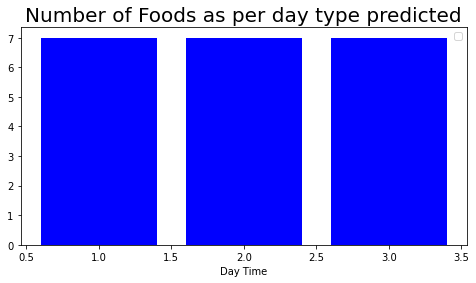

In [36]:
fig = plt.figure(figsize = (8, 4))
 
# creating the bar plot
plt.bar([1,2,3], check_list, color ='b')
plt.xlabel("Day Time")
#plt.ylabel("Max number of similar clusters")
plt.title("Number of Foods as per day type predicted",fontsize=20)
plt.legend()
plt.show()